In [5]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os

from IPython.core.display import display, HTML
from ipywidgets import *
import warnings
import matplotlib

import json
warnings.filterwarnings('ignore')

In [71]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 24

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Load Configuration

In [72]:
CONFIGURATIONS = './configurations/'
EXPERIMENT_VERSION = 'exp_v2'
config_file_name = EXPERIMENT_VERSION + '.json'

config_file_name_path = os.path.join(CONFIGURATIONS + config_file_name)

with open(config_file_name_path, 'r') as f:
    configuration = json.load(f)

In [73]:
configuration

{'metadata': {'date': 'transactiondate', 'target': 'logerror', 'kfold': 10},
 'features': {'heatingorsystemtypeid': {'missing': 'Mean',
   'category_encoding': None,
   'feature_standarization': 'Standard'},
  'regionidcity': {'missing': 'Mean',
   'category_encoding': None,
   'feature_standarization': 'MinMax'},
  'yearbuilt': {'missing': 'Mean',
   'category_encoding': None,
   'feature_standarization': 'MinMax'},
  'lotsizesquarefeet': {'missing': 'Mean',
   'category_encoding': None,
   'feature_standarization': 'Standard'},
  'taxvaluedollarcnt': {'missing': 'Mean',
   'category_encoding': None,
   'feature_standarization': 'MinMax'},
  'rawcensustractandblock': {'missing': 'Mean',
   'category_encoding': None,
   'feature_standarization': 'Standard'},
  'buildingqualitytypeid': {'missing': 'Mean',
   'category_encoding': None,
   'feature_standarization': 'Standard'}},
 'feature_selection': {'operation': 'RFE', 'num_feats': 7},
 'features_to_analyze': ['transactiondate', 'logerr

# Read Data

In [74]:
DATA_DIR = './data/'
TRAIN_DATA = os.path.join(DATA_DIR + 'base_data/train.csv')
train_df = pd.read_csv(TRAIN_DATA)

date_feature = configuration['metadata']['date']
train_df[date_feature] = pd.to_datetime(train_df[date_feature])

In [75]:
train_df.head()

,heatingorsystemtypeid,buildingqualitytypeid,propertyzoningdesc,unitcnt,lotsizesquarefeet,finishedsquarefeet12,regionidcity,calculatedbathnbr,fullbathcnt,yearbuilt,...,fips,roomcnt,regionidcounty,rawcensustractandblock,propertylandusetypeid,propertycountylandusecode,longitude,transactiondate,logerror,parcelid
0,NaN,NaN,NaN,NaN,4506.0,3100.0,53571.0,3.5,3.0,1998.0,...,6059.0,0.0,1286.0,6.059063e+07,261.0,122,-117869207.0,2017-01-01,0.025595,14297519
1,NaN,NaN,NaN,NaN,12647.0,1465.0,13091.0,1.0,1.0,1967.0,...,6111.0,5.0,2061.0,6.111001e+07,261.0,1110,-119281531.0,2017-01-01,0.055619,17052889
2,NaN,NaN,NaN,NaN,8432.0,1243.0,21412.0,2.0,2.0,1962.0,...,6059.0,6.0,1286.0,6.059022e+07,261.0,122,-117823170.0,2017-01-01,0.005383,14186244
3,2.0,8.0,LCR110000*,1.0,13038.0,2376.0,396551.0,3.0,3.0,1970.0,...,6037.0,0.0,3101.0,6.037300e+07,261.0,0101,-118240722.0,2017-01-01,-0.103410,12177905
4,2.0,8.0,LAR3,1.0,278581.0,1312.0,12447.0,3.0,3.0,1964.0,...,6037.0,0.0,3101.0,6.037124e+07,266.0,010C,-118414640.0,2017-01-01,0.006940,10887214


## Time Feature Extraction

In [76]:
train_df['dayofweek'] = train_df[date_feature].dt.dayofweek
train_df['month'] = train_df[date_feature].dt.month
train_df['day'] = train_df[date_feature].dt.day
train_df['week'] = train_df[date_feature].dt.week
train_df['year'] = train_df[date_feature].dt.year

## Missing Values

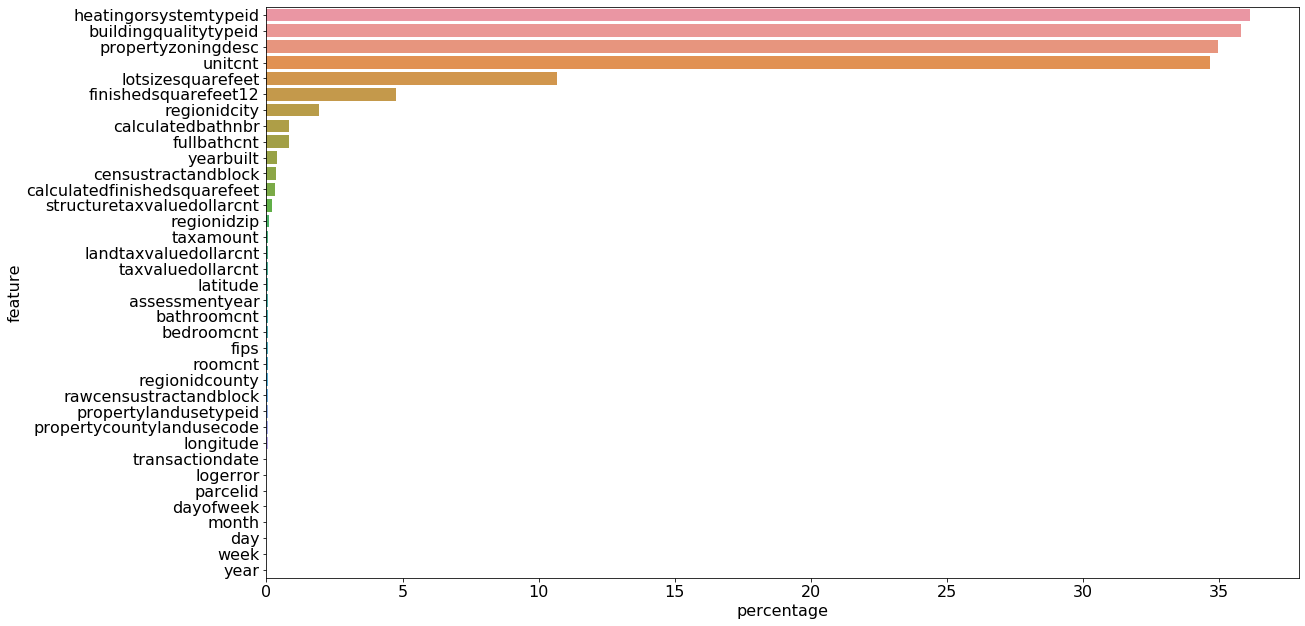

In [77]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

missing_values = train_df.isnull().sum().reset_index()
missing_values.rename(columns = {'index': "feature", 0: 'count' }, inplace = True)
missing_values['percentage'] =( missing_values["count"]/train_df.shape[0])*100
sns.barplot(x = 'percentage', y = 'feature', data = missing_values)

# Categorical Variables

In [78]:
categorical_columns = train_df.select_dtypes(include = 'object').columns

In [79]:
import cufflinks as cf
@interact
def visualize_categorical_features(Feature= list(categorical_columns)): 
    fig, ax = plt.subplots(2,3, figsize=(16, 14))
    plt.subplots_adjust(wspace=0.3)

    labels_to_consider = train_df[Feature].value_counts().head(12).index
    feature_data = train_df[train_df[Feature].isin(labels_to_consider)]
    sns.countplot(y = Feature , data = feature_data, ax = ax[0][0] )    
    sns.barplot(x = 'logerror'  , y = Feature , ax = ax[0][1], data = feature_data, ci = None)
    sns.barplot(x = "dayofweek"  , y = Feature , ax = ax[0][2], data = feature_data, ci = None)
    sns.barplot(x = "month"  , y = Feature , ax = ax[1][0], data = feature_data, ci = None)
    sns.barplot(x = "year"  , y = Feature , ax = ax[1][1], data = feature_data, ci = None)
    sns.barplot(x = "week"  , y = Feature , ax = ax[1][2], data = feature_data, ci = None)


interactive(children=(Dropdown(description='Feature', options=('propertyzoningdesc', 'propertycountylandusecod…

# Continous Variables

In [37]:
numerical_columns = train_df.select_dtypes(exclude = 'object').columns

In [80]:
import cufflinks as cf
@interact
def visualize_categorical_features(
    Feature= list(numerical_columns),
    Type = ['DensityDistribution',  'CountDistribution', 'Comparison']
): 

    target = configuration['metadata']['target']
    filtered_df = train_df[train_df[Feature].notnull()]
    buckets_feature_name = Feature+"_buckets"
    filtered_df[buckets_feature_name] = pd.cut(filtered_df[Feature], 15)
    filtered_df[buckets_feature_name] =  filtered_df[buckets_feature_name].astype('object')

    years = list(filtered_df['year'].unique())
    months = list(filtered_df['month'].unique())
    weeks = list(filtered_df['week'].unique())
    
    fig, ax = plt.subplots(1,3, figsize=(15, 10))
    
    rgb_colors = sns.color_palette("bright", 50)
    hex_colors = list(map(matplotlib.colors.rgb2hex, rgb_colors))
    
    if Type == 'DensityDistribution':
        sns.set_palette("pastel")
        for i,  year in enumerate(years):
            data = "filtered_df" + '_' + str(year)
            data = filtered_df[filtered_df.year == year]
            sns.distplot(data[Feature], ax = ax[0], hist = False, label = year, kde = True, color = hex_colors[i])
            ax[0].set_title('Density Vs Year')
            
        for i, month in enumerate(months):
            data = "filtered_df" + '_' + str(month)
            data = filtered_df[filtered_df.month == month]
            sns.distplot(data[Feature], ax = ax[1], hist = False, label = month, kde = True, color = hex_colors[i])
            ax[1].set_title('Density Vs Month')
            
        for i, week in enumerate(weeks):
            data = "filtered_df" + '_' + str(week)
            data = filtered_df[filtered_df.week == week]
            sns.distplot(data[Feature], ax = ax[2], hist = False, label = week, color = hex_colors[i])
            ax[2].set_title('Density Vs Week')
            ax[2].legend(bbox_to_anchor=(0.6,0.5))
            ax[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4)
            
    if Type == 'CountDistribution':
        plt.subplots_adjust(wspace=0.4)
        for i, year in enumerate(years):
            data = "filtered_df" + '_' + str(year)
            data = filtered_df[filtered_df.year == year]
            sns.countplot(y = data[buckets_feature_name], ax = ax[0], color = hex_colors[i], label = year)
            ax[0].set_title('Count Vs Year')
            ax[0].legend()
            
        for i,  month in enumerate(months):
            data = "filtered_df" + '_' + str(month)
            data = filtered_df[filtered_df.month == month]
            sns.countplot(y = data[buckets_feature_name], ax = ax[1], label = month, color = hex_colors[i])
            ax[1].set_title('Count Vs Month')
            ax[1].legend()
            
        for i, week in enumerate(weeks):
            data = "filtered_df" + '_' + str(week)
            data = filtered_df[filtered_df.week == week]
            sns.countplot(y = data[buckets_feature_name], ax = ax[2], label = week, color = hex_colors[i])
            ax[2].set_title('Count Vs Week')  
            ax[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.4)

            
    if Type == 'Comparison':
        sns.scatterplot(x = Feature, y = target, data = filtered_df, ax=ax[0], hue = 'week')
        sns.scatterplot(x = Feature, y = target, data = filtered_df, ax=ax[1], hue = 'month')
        sns.scatterplot(x = Feature, y = target, data = filtered_df, ax=ax[2], hue = 'year')
        ax[0].set_title("{} vs {} with {}".format(Feature, 'logerror', 'week'))
        ax[1].set_title("{} vs {} with {}".format(Feature, 'logerror', 'week'))
        ax[2].set_title("{} vs {} with {}".format(Feature, 'logerror', 'year'))


interactive(children=(Dropdown(description='Feature', options=('heatingorsystemtypeid', 'buildingqualitytypeid…